<a href="https://colab.research.google.com/github/asheta66/Machine-Learning-2020/blob/main/NLP%20Programming/chapter_10/7_compare_encodings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Acquireing dataset
!git clone https://github.com/asheta66/Machine-Learning-2020
%cd Machine-Learning-2020/Datasets/NLP
%ls

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
1 accuracy: 0.9150000214576721
2 accuracy: 0.9350000023841858
3 accuracy: 0.925000011920929
4 accuracy: 0.9200000166893005
5 accuracy: 0.9350000023841858
6 accuracy: 0.925000011920929
7 accuracy: 0.925000011920929
8 accuracy: 0.9200000166893005
9 accuracy: 0.9350000023841858
10 accuracy: 0.9399999976158142
1 accuracy: 0.8949999809265137
2 accuracy: 0.8999999761581421
3 accuracy: 0.9049999713897705
4 accuracy: 0.9100000262260437
5 accuracy: 0.8999999761581421
6 accuracy: 0.8999999761581421
7 accuracy: 0.9100000262260437
8 accuracy: 0.9049999713897705
9 accuracy: 0.8949999809265137
10 accuracy: 0.9100000262260437
1 accuracy: 0.8700000047683716
2 accuracy: 0.8999999761581421
3 accuracy: 0.8799999952316284
4 accuracy: 0.9049999713897705
5 accuracy: 0.8799999952316284
6 accuracy: 0.8700000047683716
7 accuracy: 0.875
8 accuracy: 0.8849999904632568
9 accuracy: 0.8600000143051147
10 a

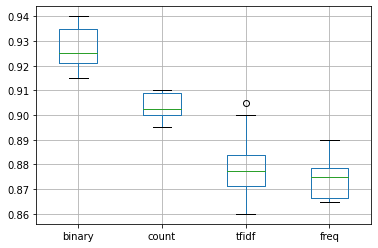

In [2]:
import string
import re
from os import listdir
from numpy import array
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense
from pandas import DataFrame
from matplotlib import pyplot

# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# turn a doc into clean tokens
def clean_doc(doc):
	# split into tokens by white space
	tokens = doc.split()
	# prepare regex for char filtering
	re_punc = re.compile('[%s]' % re.escape(string.punctuation))
	# remove punctuation from each word
	tokens = [re_punc.sub('', w) for w in tokens]
	# remove remaining tokens that are not alphabetic
	tokens = [word for word in tokens if word.isalpha()]
	# filter out stop words
	stop_words = set(stopwords.words('english'))
	tokens = [w for w in tokens if not w in stop_words]
	# filter out short tokens
	tokens = [word for word in tokens if len(word) > 1]
	return tokens

# load doc, clean and return line of tokens
def doc_to_line(filename, vocab):
	# load the doc
	doc = load_doc(filename)
	# clean doc
	tokens = clean_doc(doc)
	# filter by vocab
	tokens = [w for w in tokens if w in vocab]
	return ' '.join(tokens)

# load all docs in a directory
def process_docs(directory, vocab, is_train):
	lines = list()
	# walk through all files in the folder
	for filename in listdir(directory):
		# skip any reviews in the test set
		if is_train and filename.startswith('cv9'):
			continue
		if not is_train and not filename.startswith('cv9'):
			continue
		# create the full path of the file to open
		path = directory + '/' + filename
		# load and clean the doc
		line = doc_to_line(path, vocab)
		# add to list
		lines.append(line)
	return lines

# load and clean a dataset
def load_clean_dataset(vocab, is_train):
	# load documents
	neg = process_docs('txt_sentoken/neg', vocab, is_train)
	pos = process_docs('txt_sentoken/pos', vocab, is_train)
	docs = neg + pos
	# prepare labels
	labels = array([0 for _ in range(len(neg))] + [1 for _ in range(len(pos))])
	return docs, labels

# define the model
def define_model(n_words):
	# define network
	model = Sequential()
	model.add(Dense(50, input_shape=(n_words,), activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# compile network
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

# evaluate a neural network model
def evaluate_mode(Xtrain, ytrain, Xtest, ytest):
	scores = list()
	n_repeats = 10
	n_words = Xtest.shape[1]
	for i in range(n_repeats):
		# define network
		model = define_model(n_words)
		# fit network
		model.fit(Xtrain, ytrain, epochs=10, verbose=0)
		# evaluate
		_, acc = model.evaluate(Xtest, ytest, verbose=0)
		scores.append(acc)
		print('%d accuracy: %s' % ((i+1), acc))
	return scores

# prepare bag of words encoding of docs
def prepare_data(train_docs, test_docs, mode):
	# create the tokenizer
	tokenizer = Tokenizer()
	# fit the tokenizer on the documents
	tokenizer.fit_on_texts(train_docs)
	# encode training data set
	Xtrain = tokenizer.texts_to_matrix(train_docs, mode=mode)
	# encode training data set
	Xtest = tokenizer.texts_to_matrix(test_docs, mode=mode)
	return Xtrain, Xtest

# load the vocabulary
vocab_filename = 'vocab.txt'
vocab = load_doc(vocab_filename)
vocab = set(vocab.split())
# load all reviews
train_docs, ytrain = load_clean_dataset(vocab, True)
test_docs, ytest = load_clean_dataset(vocab, False)
# run experiment
modes = ['binary', 'count', 'tfidf', 'freq']
results = DataFrame()
for mode in modes:
	# prepare data for mode
	Xtrain, Xtest = prepare_data(train_docs, test_docs, mode)
	# evaluate model on data for mode
	results[mode] = evaluate_mode(Xtrain, ytrain, Xtest, ytest)
# summarize results
print(results.describe())
# plot results
results.boxplot()
pyplot.show()
